In [36]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [37]:
data = pd.read_csv('Wave7.csv')
data.head()

,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,D_INTERVIEW,S007,J_INTDATE,FW_START,FW_END,K_TIME_START,K_TIME_END,K_DURATION,Q_MODE,N_REGION_ISO,N_REGION_WVS,N_REGION_NUTS2,N_REG_NUTS1,N_TOWN,G_TOWNSIZE,G_TOWNSIZE2,H_SETTLEMENT,H_URBRURAL,I_PSU,O1_LONGITUDE,O2_LATITUDE,L_INTERVIEWER_NUMBER,S_INTLANGUAGE,LNGE_ISO,E_RESPINT,F_INTPRIVACY,E1_LITERACY,W_WEIGHT,S018,PWGHT,S025,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q33_3,Q34,Q34_3,Q35,Q35_3,Q36,Q37,Q38,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Q55,Q56,Q57,Q58,Q59,Q60,Q61,Q62,Q63,Q64,Q65,Q66,Q67,Q68,Q69,Q70,Q71,Q72,Q73,Q74,Q75,Q76,Q77,Q78,Q79,Q80,Q81,Q82,Q82_AFRICANUNION,Q82_APEC,Q82_ARABLEAGUE,Q82_ASEAN,Q82_CIS,Q82_CUSMA,Q82_ECO,Q82_EU,Q82_GULFCOOP,Q82_ISLCOOP,Q82_MERCOSUR,Q82_NAFTA,Q82_OAS,Q82_SAARC,Q82_SCO,Q82_TLC,Q82_UNDP,Q83,Q84,Q85,Q86,Q87,Q88,Q89,Q90,Q91,Q92,Q93,Q94,Q94R,Q95,Q95R,Q96,Q96R,Q97,Q97R,Q98,Q98R,Q99,Q99R,Q100,Q100R,Q101,Q101R,Q102,Q102R,Q103,Q103R,Q104,Q104R,Q105,Q105R,Q106,Q107,Q108,Q109,Q110,Q111,Q112,Q113,Q114,Q115,Q116,Q117,Q118,Q119,Q120,Q121,Q122,Q123,Q124,Q125,Q126,Q127,Q128,Q129,Q130,Q131,Q132,Q133,Q134,Q135,Q136,Q137,Q138,Q139,Q140,Q141,Q142,Q143,Q144,Q145,Q146,Q147,Q148,Q149,Q150,Q151,Q152,Q153,Q154,Q155,Q156,Q157,Q158,Q159,Q160,Q161,Q162,Q163,Q164,Q165,Q166,Q167,Q168,Q169,Q170,Q171,Q172,Q172R,Q173,Q174,Q175,Q176,Q177,Q178,Q179,Q180,Q181,Q182,Q183,Q184,Q185,Q186,Q187,Q188,Q189,Q190,Q191,Q192,Q193,Q194,Q195,Q196,Q197,Q198,Q199,Q200,Q201,Q202,Q203,Q204,Q205,Q206,Q207,Q208,Q209,Q210,Q211,Q212,Q213,Q214,Q215,Q216,Q217,Q218,Q219,Q220,Q221,Q222,Q223,Q223_ABREV,Q223_LOCAL,Q224,Q225,Q226,Q227,Q228,Q229,Q230,Q231,Q232,Q233,Q234,Q234A,Q235,Q236,Q237,Q238,Q239,Q240,Q241,Q242,Q243,Q244,Q245,Q246,Q247,Q248,Q249,Q250,Q251,Q252,Q253,Q254,Q255,Q256,Q257,Q258,Q259,Q260,Q261,Q262,X003R,X003R2,Q263,Q264,V002,Q265,V001,Q266,X002_02B,Q267,V002A_01,Q268,V001A_01,Q269,Q270,Q271,Q272,Q273,Q274,Q275,Q275A,Q275R,Q276,Q276A,Q276R,Q277,Q277A,Q277R,Q278,Q278A,Q278R,Q279,Q280,Q281,Q282,Q283,Q284,Q285,Q286,Q287,Q288,Q288R,Q289,Q289CS9,Q290,Q291G1,Q291G2,Q291G3,Q291G4,Q291G5,Q291G6,Q291P1,Q291P2,Q291P3,Q291P4,Q291P5,Q291P6,Q291UN1,Q291UN2,Q291UN3,Q291UN4,Q291UN5,Q291UN6,Q292A,Q292B,Q292C,Q292D,Q292E,Q292F,Q292G,Q292H,Q292I,Q292J,Q292K,Q292L,Q292M,Q292N,Q292O,Q293,Q294A,Q294B,Y001,Y002,Y003,SACSECVAL,RESEMAVAL,I_AUTHORITY,I_NATIONALISM,I_DEVOUT,DEFIANCE,I_RELIGIMP,I_RELIGBEL,I_RELIGPRAC,DISBELIEF,I_NORM1,I_NORM2,I_NORM3,RELATIVISM,I_TRUSTARMY,I_TRUSTPOLICE,I_TRUSTCOURTS,SCEPTICISM,I_INDEP,I_IMAGIN,I_NONOBED,AUTONOMY,I_WOMJOB,I_WOMPOL,I_WOMEDU,EQUALITY,I_HOMOLIB,I_ABORTLIB,I_DIVORLIB,CHOICE,I_VOICE1,I_VOICE2,I_VOI2_00,VOICE,SECVALWGT,RESEMAVALWGT,fhregion,polregfh,freestfh,prfhrat,prfhscore,clfhrat,clfhscore,democ,autoc,polity,durable,regtype,ruleoflaw,corrupttransp,electintegr,btiregion,btistatus,btidemstatus,btistate,btipolpart,btiruleoflaw,btistability,btiintegration,btimarket,btigovindex,btigoveperform,btiregime,regionWB,incomeWB,landWB,GDPpercap1,GDPpercap2,giniWB,incrichest10p,popWB1990,popWB2000,popWB2019,lifeexpect,popgrowth,urbanpop,laborforce,deathrate,unemployfem,unemploymale,unemploytotal,accessclfuel,accesselectr,renewelectr,co2emis,co2percap,easeofbusiness,militaryexp,Trade,healthexp,educationexp,medageun,meanschooling,educationHDI,compulseduc,GII,DGI,womenparl,hdi,incomeindexHDI,humanineqiality,lifeexpectHDI,homiciderate,Refugeesorigin,internetusers,mobphone,migrationrate,schoolgpi,femchoutsch,choutsch,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem,v2x_freexp_altinf,v2x_frassoc_thick,v2xel_frefair,v2xcl_rol,v2x_cspart,v2xeg_eqdr,v2excrptps,v2exthftps,v2juaccnt,v2cltrnslw,v2clacjust,v2clsocgrp,v2clacfree,v2clrelig,v2csrlgrep,v2mecenefm,v2mecenefi,v2mebias,v2pepwrses,v2pepwrgen,v2peedueq,v2pehealth,v2peapsecon,v2peasjsoecon,v2clgencl,v2peasjgen,v2peasbgen,v2cafres,v2cafexch,v2x_corr,v2x_gender,v2x_gencl,v2x_genpp,v2x_rul

In [38]:
# countries = data[(data['B_COUNTRY_ALPHA'] == 'IND') | (data['B_COUNTRY_ALPHA'] == 'USA') | (data['B_COUNTRY_ALPHA'] == 'DEU')]

data[(data['B_COUNTRY_ALPHA'] == 'USA') | (data['B_COUNTRY_ALPHA'] == 'IND')].shape

(4288, 613)

In [39]:
usa = data[(data['B_COUNTRY_ALPHA'] == 'USA')]
usa.reset_index(drop = True, inplace = True)

cat_cols = list(set(usa.columns)-{'Y001','Y002','Y003','SACSECVAL', 'RESEMAVAL','I_AUTHORITY',  'I_NATIONALISM',  'I_DEVOUT',  'DEFIANCE',  'I_RELIGIMP',  'I_RELIGBEL',  'I_RELIGPRAC',  'DISBELIEF',  'I_NORM1',  'I_NORM2',  'I_NORM3',  'RELATIVISM',  'I_TRUSTARMY',  'I_TRUSTPOLICE',  'I_TRUSTCOURTS',  'SCEPTICISM',  'I_INDEP',  'I_IMAGIN',  'I_NONOBED',  'AUTONOMY',  'I_WOMJOB',  'I_WOMPOL',  'I_WOMEDU',  'EQUALITY',  'I_HOMOLIB',  'I_ABORTLIB',  'I_DIVORLIB',  'CHOICE',  'I_VOICE1',  'I_VOICE2',  'I_VOI2_00',  'VOICE',  'SECVALWGT',  'RESEMAVALWGT'})
usa[cat_cols] = usa[cat_cols].astype('category')

pd.options.display.max_columns = None

required_cols = ['B_COUNTRY_ALPHA','Q222','Q221','Q48','Q49','Q50','Q260','Q262','Q263','Q274','Q288','Q275','Q164','Q172R','Q177','Q178','Q179','Q180','Q181','Q182','Q183','Q184','Q185','Q186','Q187','Q188','Q189','Q190','Q191','Q192','Q193','Q194','Q195']
usa = usa[required_cols]

ethical_values = ['Q177','Q178','Q179','Q180','Q181','Q182','Q183','Q184','Q185','Q186','Q187','Q188','Q189','Q190','Q191','Q192','Q193','Q194','Q195']

# reverse the score for columns such that in the end 1 is bad and 10 is good
reverse_scoring = ['Q177','Q178','Q179','Q180','Q181','Q183','Q187','Q188','Q189','Q190','Q191','Q192','Q194','Q195']

for col in ethical_values:
    usa[col] = pd.to_numeric(usa[col], errors='coerce')  # Convert to numeric, NaNs for invalid
    usa[col] = usa[col].where(usa[col] >= 0, np.nan)  # Replace negative values with NaN

for col in reverse_scoring:
    usa[col] = 11 - usa[col]

# Ethics score is the average score of all questions
usa['ethics_score'] = usa[ethical_values].mean(axis=1)

# Normalized ethics score
min_score = usa['ethics_score'].min()
max_score = usa['ethics_score'].max()
usa['ethics_score'] = 10 * (usa['ethics_score'] - min_score) / (max_score - min_score)

usa.drop(columns=ethical_values, inplace=True)

usa.rename(columns={
    'Q262':'age', 
    'Q263':'immigrant', 
    'Q274':'children', 
    'Q275':'education', 
    'Q260':'sex', 
    'Q222':'voter_national',
    'Q221':'voter_local',
    'Q164':'god_importance',
    'Q172R':'praying_frequency',
    'Q48':'freedom',
    'Q49':'satisfaction',
    'Q50':'financial_wellbeing',
    'Q288':'income_level',
    'B_COUNTRY_ALPHA':'country'
    }, inplace=True)

# For each respondent:
#     IF voter_national == 4 OR voter_local == 4 THEN
#         target = 0  # Not allowed to vote
#     ELSE:
#         IF voter_national == 1 OR voter_local == 1 THEN
#             target = 3  # Always votes (high engagement)
#         ELSE IF voter_national == 2 OR voter_local == 2 THEN
#             IF voter_national == 3 OR voter_local == 3 THEN
#                 target = 1  # Sometimes votes but inconsistent
#             ELSE:
#                 target = 2  # Usually votes
#         ELSE:
#             target = 1  # Never votes (low engagement)
usa['voter_4'] = -1
for i in range(len(usa)):
    national = usa.loc[i, 'voter_national']
    local = usa.loc[i, 'voter_local']

    if national == 4 | local == 4:
        usa.loc[i, 'voter_4'] = 1
    elif national == 1 | local == 1:
        usa.loc[i, 'voter_4'] = 3
    elif national == 2 | local == 2:
        if national == 3 | local == 3:
            usa.loc[i, 'voter_4'] = 1
        else:
            usa.loc[i, 'voter_4'] = 2
    else:
        usa.loc[i, 'voter_4'] = 1
usa['voter_2'] = np.where(usa['voter_national'].isin([4]) | usa['voter_local'].isin([4]),0,np.where(usa['voter_national'].isin([1,2]) | usa['voter_local'].isin([1,2]),1,0))

usa.drop(columns=['voter_national','voter_local'], inplace=True)

# Set datatypes

usa[['freedom','satisfaction','financial_wellbeing','god_importance', 'age', 'children']] = usa[['freedom','satisfaction','financial_wellbeing','god_importance', 'age', 'children']].astype('int')
usa[['income_level', 'education', 'praying_frequency', 'voter_2', 'voter_4']] = usa[['income_level', 'education', 'praying_frequency', 'voter_2', 'voter_4']].astype('int')
# usa[['immigrant', 'sex', 'income_level', 'education', 'praying_frequency', 'voter_2', 'voter_4']] = usa[['immigrant', 'sex', 'income_level', 'education', 'praying_frequency', 'voter_2', 'voter_4']].astype('category')
usa['country'] = usa['country'].astype('str')
usa['ethics_score'] = usa['ethics_score'].astype('float').apply(lambda x: round(x, 2))

to_clean = ['freedom', 'satisfaction', 'financial_wellbeing', 'immigrant', 'children', 'income_level', 'education', 'god_importance', 'praying_frequency', 'voter_2', 'voter_4']
for col in to_clean:
    usa[col] = np.where(usa[col].astype(int) >= 0, usa[col], None)

usa['sex'] = np.where(usa['sex'] == 1, 'Male', 'Female')
usa['immigrant'] = np.where(usa['immigrant'] == 1, 'Not immigrant', 'Immigrant')

# usa.to_csv('cleaned_dataset.csv')

usa.head()


,country,freedom,satisfaction,financial_wellbeing,sex,age,immigrant,children,income_level,education,god_importance,praying_frequency,ethics_score,voter_4,voter_2
0,USA,7,4,2,Female,43,Not immigrant,6,3,4,10,1,NaN,1,1
1,USA,6,10,5,Female,35,Not immigrant,5,5,2,3,1,6.84,1,0
2,USA,10,10,10,Female,48,Not immigrant,2,1,3,10,1,9.12,1,0
3,USA,10,8,7,Female,49,Not immigrant,3,1,3,10,1,7.71,1,0
4,USA,4,7,5,Female,20,Not immigrant,0,5,3,10,2,7.96,1,0


In [40]:
ind = data[(data['B_COUNTRY_ALPHA'] == 'IND')]
ind.reset_index(drop = True, inplace = True)

cat_cols = list(set(ind.columns)-{'Y001','Y002','Y003','SACSECVAL', 'RESEMAVAL','I_AUTHORITY',  'I_NATIONALISM',  'I_DEVOUT',  'DEFIANCE',  'I_RELIGIMP',  'I_RELIGBEL',  'I_RELIGPRAC',  'DISBELIEF',  'I_NORM1',  'I_NORM2',  'I_NORM3',  'RELATIVISM',  'I_TRUSTARMY',  'I_TRUSTPOLICE',  'I_TRUSTCOURTS',  'SCEPTICISM',  'I_INDEP',  'I_IMAGIN',  'I_NONOBED',  'AUTONOMY',  'I_WOMJOB',  'I_WOMPOL',  'I_WOMEDU',  'EQUALITY',  'I_HOMOLIB',  'I_ABORTLIB',  'I_DIVORLIB',  'CHOICE',  'I_VOICE1',  'I_VOICE2',  'I_VOI2_00',  'VOICE',  'SECVALWGT',  'RESEMAVALWGT'})
ind[cat_cols] = ind[cat_cols].astype('category')

pd.options.display.max_columns = None

required_cols = ['B_COUNTRY_ALPHA','Q222','Q221','Q48','Q49','Q50','Q260','Q262','Q263','Q274','Q288','Q275','Q164','Q172R','Q177','Q178','Q179','Q180','Q181','Q182','Q183','Q184','Q185','Q186','Q187','Q188','Q189','Q190','Q191','Q192','Q193','Q194','Q195']
ind = ind[required_cols]

ethical_values = ['Q177','Q178','Q179','Q180','Q181','Q182','Q183','Q184','Q185','Q186','Q187','Q188','Q189','Q190','Q191','Q192','Q193','Q194','Q195']

# reverse the score for columns such that in the end 1 is bad and 10 is good
reverse_scoring = ['Q177','Q178','Q179','Q180','Q181','Q183','Q187','Q188','Q189','Q190','Q191','Q192','Q194','Q195']

for col in ethical_values:
    ind[col] = pd.to_numeric(ind[col], errors='coerce')  # Convert to numeric, NaNs for invalid
    ind[col] = ind[col].where(ind[col] >= 0, np.nan)  # Replace negative values with NaN

for col in reverse_scoring:
    ind[col] = 11 - ind[col]

# Ethics score is the average score of all questions
ind['ethics_score'] = ind[ethical_values].mean(axis=1)

# Normalized ethics score
min_score = ind['ethics_score'].min()
max_score = ind['ethics_score'].max()
ind['ethics_score'] = 10 * (ind['ethics_score'] - min_score) / (max_score - min_score)

ind.drop(columns=ethical_values, inplace=True)

ind.rename(columns={
    'Q262':'age', 
    'Q263':'immigrant', 
    'Q274':'children', 
    'Q275':'education', 
    'Q260':'sex', 
    'Q222':'voter_national',
    'Q221':'voter_local',
    'Q164':'god_importance',
    'Q172R':'praying_frequency',
    'Q48':'freedom',
    'Q49':'satisfaction',
    'Q50':'financial_wellbeing',
    'Q288':'income_level',
    'B_COUNTRY_ALPHA':'country'
    }, inplace=True)

# For each respondent:
#     IF voter_national == 4 OR voter_local == 4 THEN
#         target = 0  # Not allowed to vote
#     ELSE:
#         IF voter_national == 1 OR voter_local == 1 THEN
#             target = 3  # Always votes (high engagement)
#         ELSE IF voter_national == 2 OR voter_local == 2 THEN
#             IF voter_national == 3 OR voter_local == 3 THEN
#                 target = 1  # Sometimes votes but inconsistent
#             ELSE:
#                 target = 2  # Usually votes
#         ELSE:
#             target = 1  # Never votes (low engagement)
ind['voter_4'] = -1
for i in range(len(ind)):
    national = ind.loc[i, 'voter_national']
    local = ind.loc[i, 'voter_local']

    if national == 4 | local == 4:
        ind.loc[i, 'voter_4'] = 1
    elif national == 1 | local == 1:
        ind.loc[i, 'voter_4'] = 3
    elif national == 2 | local == 2:
        if national == 3 | local == 3:
            ind.loc[i, 'voter_4'] = 1
        else:
            ind.loc[i, 'voter_4'] = 2
    else:
        ind.loc[i, 'voter_4'] = 1
ind['voter_2'] = np.where(ind['voter_national'].isin([4]) | ind['voter_local'].isin([4]),0,np.where(ind['voter_national'].isin([1,2]) | ind['voter_local'].isin([1,2]),1,0))

ind.drop(columns=['voter_national','voter_local'], inplace=True)

# Set datatypes

ind[['freedom','satisfaction','financial_wellbeing','god_importance', 'age', 'children']] = ind[['freedom','satisfaction','financial_wellbeing','god_importance', 'age', 'children']].astype('int')
ind[['income_level', 'education', 'praying_frequency', 'voter_2', 'voter_4']] = ind[['income_level', 'education', 'praying_frequency', 'voter_2', 'voter_4']].astype('int')
# ind[['immigrant', 'sex', 'income_level', 'education', 'praying_frequency', 'voter_2', 'voter_4']] = ind[['immigrant', 'sex', 'income_level', 'education', 'praying_frequency', 'voter_2', 'voter_4']].astype('category')
ind['country'] = ind['country'].astype('str')
ind['ethics_score'] = ind['ethics_score'].astype('float').apply(lambda x: round(x, 2))

to_clean = ['freedom', 'satisfaction', 'financial_wellbeing', 'immigrant', 'children', 'income_level', 'education', 'god_importance', 'praying_frequency', 'voter_2', 'voter_4']
for col in to_clean:
    ind[col] = np.where(ind[col].astype(int) >= 0, ind[col], None)

ind['sex'] = np.where(ind['sex'] == 1, 'Male', 'Female')
ind['immigrant'] = np.where(ind['immigrant'] == 1, 'Not immigrant', 'Immigrant')

# ind.to_csv('cleaned_dataset.csv')

ind.head()


,country,freedom,satisfaction,financial_wellbeing,sex,age,immigrant,children,income_level,education,god_importance,praying_frequency,ethics_score,voter_4,voter_2
0,IND,6,4,5,Female,20,Not immigrant,None,4,6,8,1,6.88,3,1
1,IND,9,6,6,Male,63,Not immigrant,3,5,3,10,1,6.48,1,1
2,IND,10,10,10,Male,17,Not immigrant,None,1,1,1,1,5.68,3,1
3,IND,7,5,6,Female,68,Not immigrant,4,7,0,10,1,4.00,3,1
4,IND,10,7,4,Male,55,Not immigrant,1,4,6,10,1,5.44,3,1


In [41]:
cleaned_dataset = pd.concat([ind,usa])
cleaned_dataset['children'].fillna(0, inplace=True)
cleaned_dataset.head()

,country,freedom,satisfaction,financial_wellbeing,sex,age,immigrant,children,income_level,education,god_importance,praying_frequency,ethics_score,voter_4,voter_2
0,IND,6,4,5,Female,20,Not immigrant,0,4,6,8,1,6.88,3,1
1,IND,9,6,6,Male,63,Not immigrant,3,5,3,10,1,6.48,1,1
2,IND,10,10,10,Male,17,Not immigrant,0,1,1,1,1,5.68,3,1
3,IND,7,5,6,Female,68,Not immigrant,4,7,0,10,1,4.00,3,1
4,IND,10,7,4,Male,55,Not immigrant,1,4,6,10,1,5.44,3,1


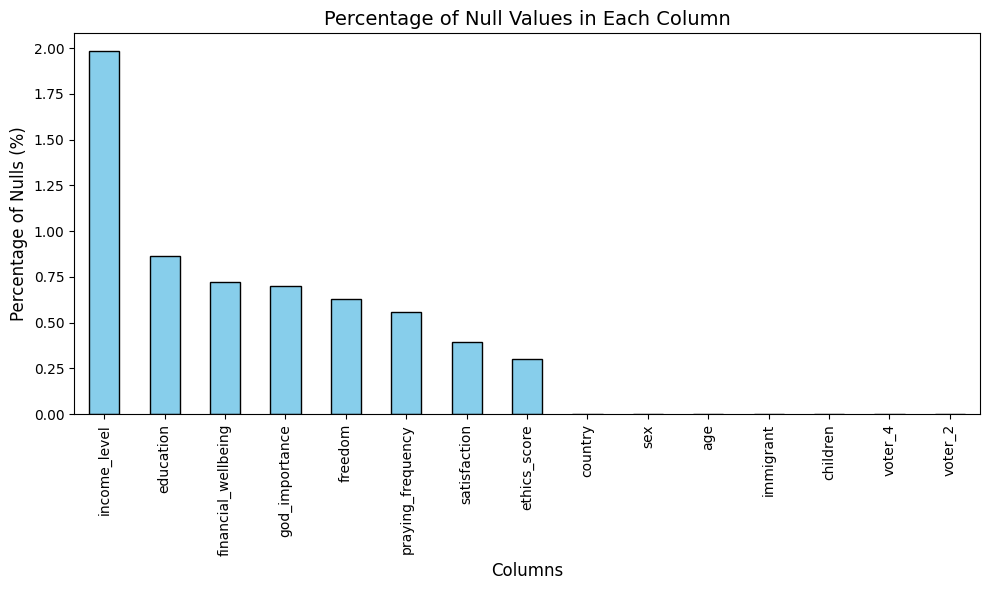

In [42]:
import matplotlib.pyplot as plt

# Calculate the percentage of null values for each column
null_percentages = cleaned_dataset.isna().mean() * 100

# Plot the percentages
plt.figure(figsize=(10, 6))
null_percentages.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Null Values in Each Column', fontsize=14)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Percentage of Nulls (%)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [43]:
filtered_dataset = cleaned_dataset.dropna()

min_samples_per_country = 500
countries = ["IND", "USA"]
sampled_dataframes = []

for country in countries:
    country_data = filtered_dataset[filtered_dataset['country'] == country]
    
    # Stratified sampling based on voter_2 and voter_4
    stratified_sample = country_data.groupby(['voter_2', 'voter_4'], group_keys=False).apply(
        lambda x: x.sample(n=min_samples_per_country // len(countries), replace=True)
    )
    sampled_dataframes.append(stratified_sample)

# Combine samples and shuffle
sampled_data = pd.concat(sampled_dataframes).sample(frac=1, random_state=42).reset_index(drop=True)
sampled_data.head()

,country,freedom,satisfaction,financial_wellbeing,sex,age,immigrant,children,income_level,education,god_importance,praying_frequency,ethics_score,voter_4,voter_2
0,USA,10,8,8,Female,35,Not immigrant,2,5,4,5,2,6.22,3,1
1,IND,4,10,5,Female,31,Not immigrant,2,4,6,10,1,6.71,1,1
2,USA,7,7,7,Male,59,Not immigrant,0,8,6,6,2,7.40,1,1
3,IND,10,9,8,Male,44,Not immigrant,2,7,7,7,1,6.40,3,1
4,USA,8,5,1,Female,28,Immigrant,2,2,5,7,2,8.27,1,1


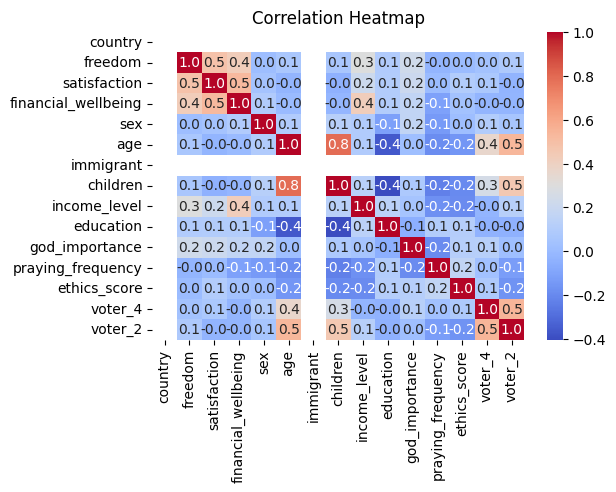

In [45]:
# cleaned_dataset.reset_index(inplace=True, drop=True)

cleaned_dataset_numeric = sampled_data.copy(deep=True)
cleaned_dataset_numeric['country'] = np.where(cleaned_dataset_numeric['country'] == 'IND', 0, 1)
cleaned_dataset_numeric['sex'] = np.where(cleaned_dataset_numeric['sex'] == 'Female', 1, 0)
cleaned_dataset_numeric['immigrant'] = np.where(cleaned_dataset_numeric['immigrant'] == 'Not immigrant', 0, 1)
cleaned_dataset_numeric = cleaned_dataset_numeric[cleaned_dataset_numeric['country'] == 0]
# ind = cleaned_dataset_numeric[cleaned_dataset_numeric['country'] == 0]
# usa = cleaned_dataset_numeric[cleaned_dataset_numeric['country'] == 1]

corr_matrix = cleaned_dataset_numeric.corr(method='spearman')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Correlation Heatmap")
plt.show()

financial well being vs income level: 0.4   
satisfaction vs freedom: 0.4   
financial well being vs freedom: 0.4  
financial well being vs satisfaction: 0.5  

Remove financial well being, freedom

In [46]:
sampled_data.drop(columns=['financial_wellbeing', 'freedom'], inplace=True)

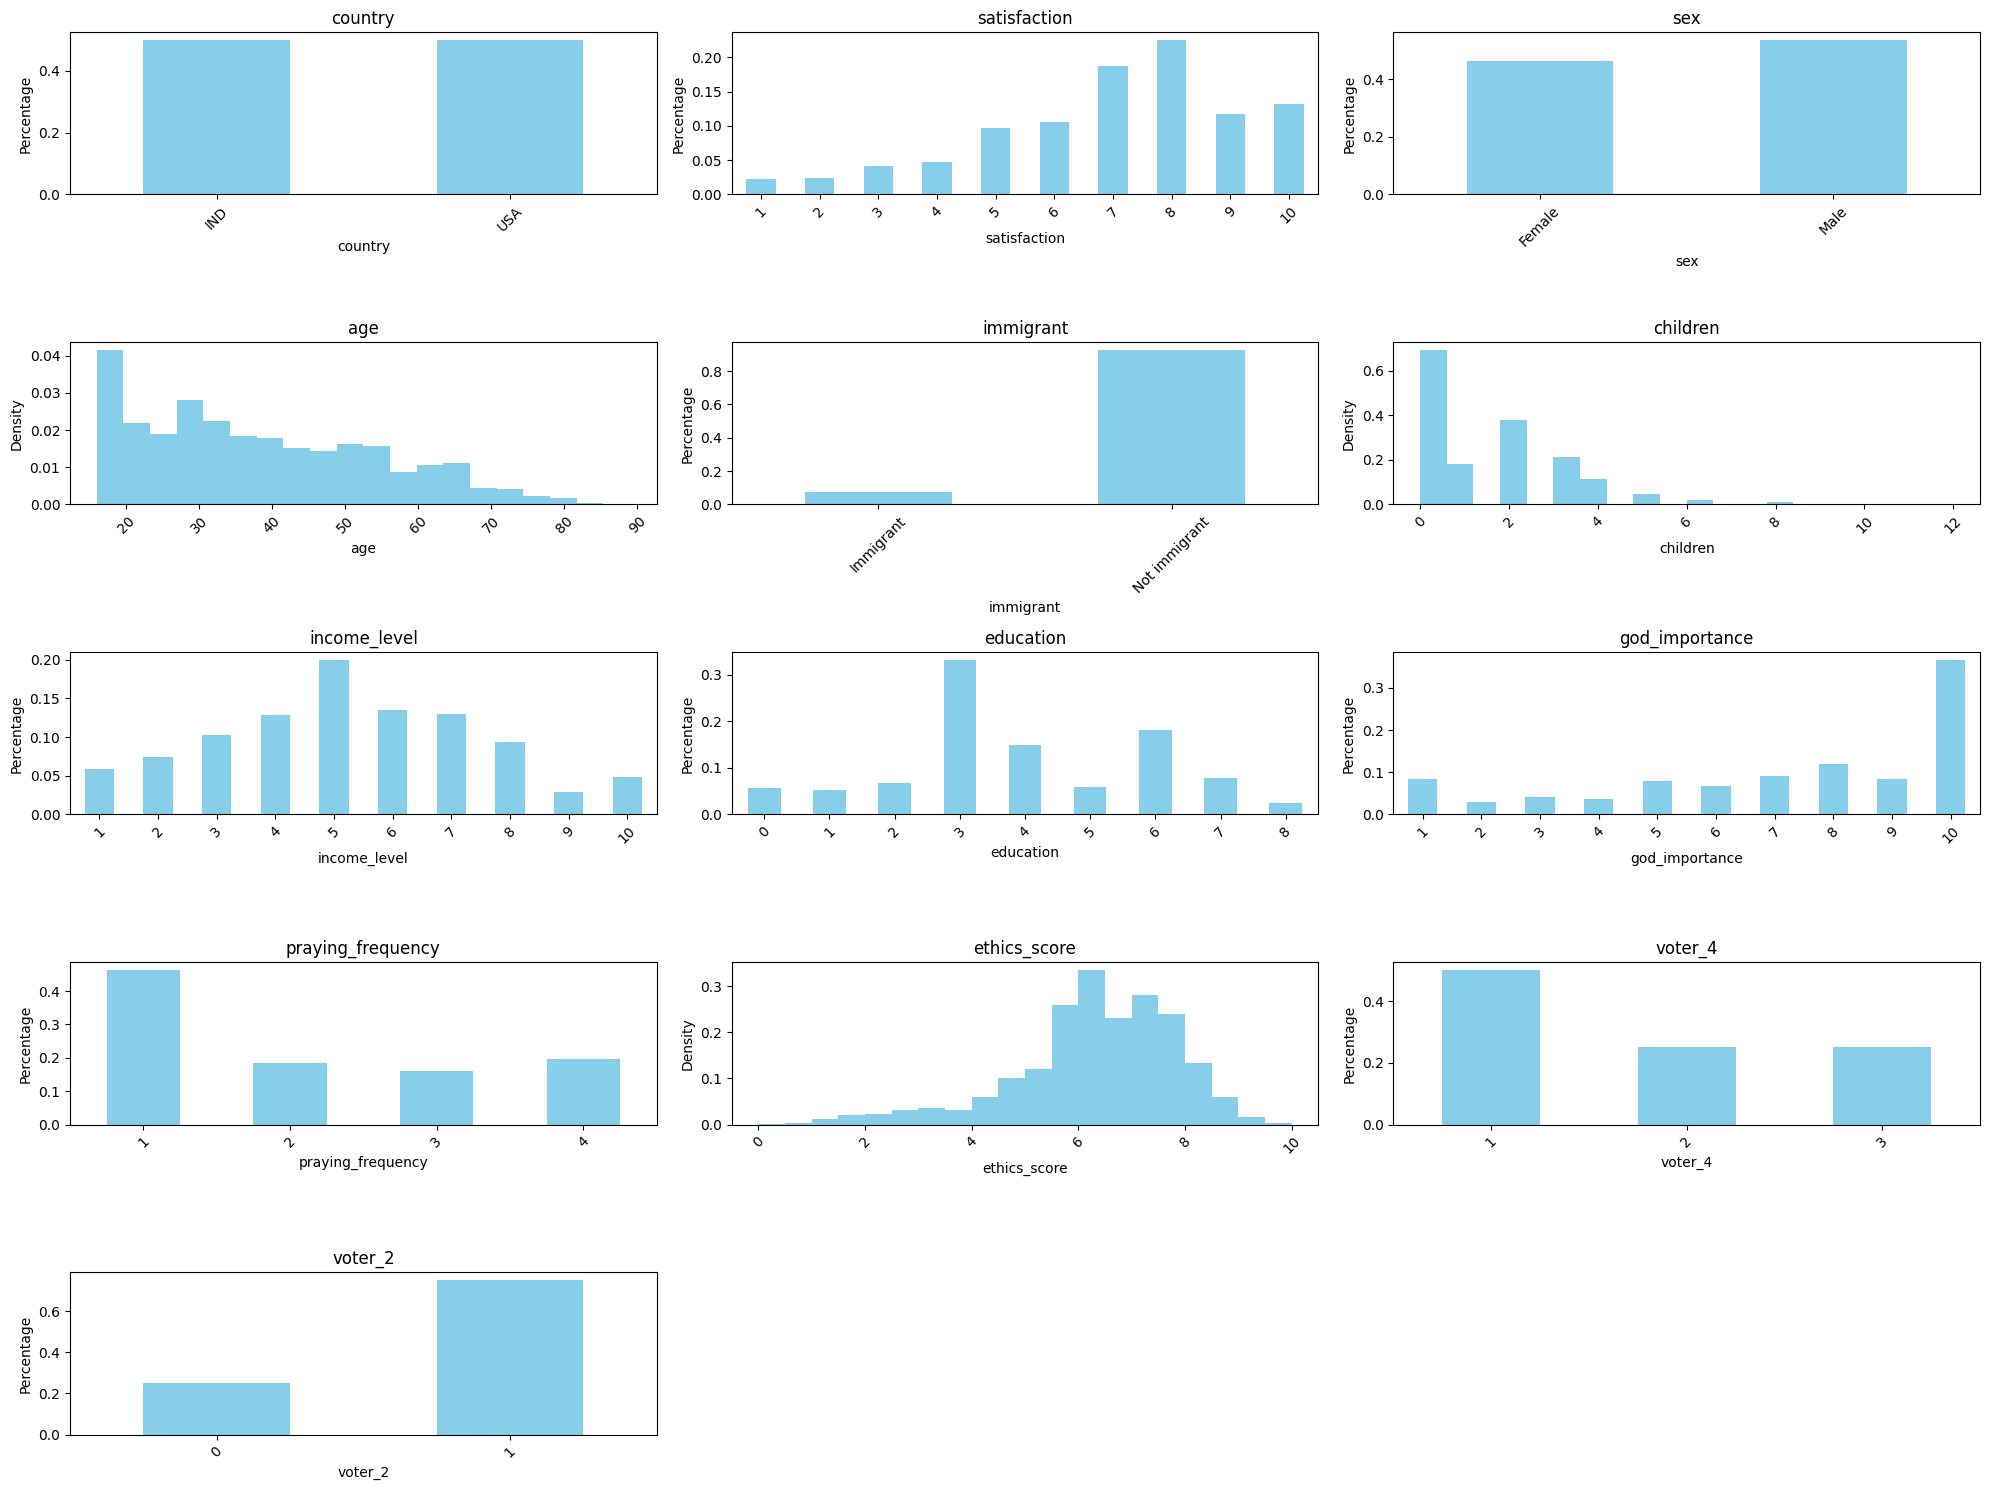

In [48]:
import matplotlib.pyplot as plt

# Plot histograms for each column
columns = sampled_data.columns
num_columns = len(columns)

plt.figure(figsize=(20, 15))

for i, column in enumerate(columns):
    plt.subplot((num_columns // 3) + 1, 3, i + 1)
    
    # Plot histogram for numeric columns
    if sampled_data[column].dtype in ['int64', 'float64']:
        sampled_data[column].plot(kind='hist', bins=20, color='skyblue', density=True)
        plt.title(f'{column}')
        plt.xlabel(column)
        plt.ylabel('Density')
    # Plot histogram for categorical columns
    else:
        sampled_data[column].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
        plt.title(f'{column}')
        plt.xlabel(column)
        plt.ylabel('Percentage')
    
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [49]:
sampled_data.to_csv('resample_data.csv', index=False)